In [1]:
import os, sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

# Dataset, dataloader
import torch.utils.data as Data
from torchvision import transforms

# Model
import torch.nn as nn
import torch.nn.functional as F

# Training
from torch.autograd import Variable

# Progress bar
from tqdm import tqdm

# Save file
from datetime import date

# Confusion Matrix
import sklearn.metrics as skm

# import from parent dir
sys.path.insert(1, os.path.realpath(os.path.pardir))    #sys.path.append('../')
from utils import read_json, prepare_device, ROOT_DIR
import data_loader.data_loaders as module_data
import model.model as module_arch
import model.loss as module_loss
import model.metric as module_metric
from parse_config import ConfigParser
from trainer import Trainer
from base import BaseModel

import warnings
warnings.filterwarnings('ignore')

In [2]:
par_dir = os.path.realpath(os.path.pardir)
cur_dir = os.getcwd()
csv_dir = os.path.join(ROOT_DIR, 'data', 'train_pivot.csv')

print("Parent dir: {}".format(par_dir))
print("Current dir: {}".format(cur_dir))
print('Root dir: {}'.format(ROOT_DIR))
print('Img dir: {}'.format(csv_dir))

Parent dir: E:\jupyter-notebook\Kaggle\Steel-Defect-Detection-Pytorch
Current dir: e:\jupyter-notebook\Kaggle\Steel-Defect-Detection-Pytorch\notebook
Root dir: E:\jupyter-notebook\Kaggle\Steel-Defect-Detection-Pytorch\utils\..
Img dir: E:\jupyter-notebook\Kaggle\Steel-Defect-Detection-Pytorch\utils\..\data\train_pivot.csv


In [3]:
# testing if dir is correct
pd.read_csv(csv_dir)

,ImageId,1,2,3,4
0,0002cc93b.jpg,True,False,False,False
1,00031f466.jpg,False,False,False,False
2,000418bfc.jpg,False,False,False,False
3,000789191.jpg,False,False,False,False
4,0007a71bf.jpg,False,False,True,False
...,...,...,...,...,...
12563,fff0295e1.jpg,False,False,False,False
12564,fff02e9c5.jpg,False,False,True,False
12565,fffe98443.jpg,False,False,True,False
12566,ffff4eaa8.jpg,False,False,True,False


In [4]:
# load model
model = module_arch.FirstHalfUNet(in_channels=1, out_classes=4, use_resnet=False)
print(model)

FirstHalfUNet(
  (bn_input): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (down_conv1): DownBlock(
    (double_conv): DoubleConv(
      (conv1): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (convRes): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv2): DownBlock(
    (double_conv): DoubleConv(
      (conv1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), paddin

In [5]:
resume_path = '.././saved/models/Steel_Defect_Detection/0530_225114/model_best.pth'
checkpoint = torch.load(resume_path)
print(checkpoint)

{'arch': 'FirstHalfUNet', 'epoch': 40, 'state_dict': OrderedDict([('bn_input.weight', tensor([0.7935], device='cuda:0')), ('bn_input.bias', tensor([0.0885], device='cuda:0')), ('bn_input.running_mean', tensor([0.3521], device='cuda:0')), ('bn_input.running_var', tensor([0.0392], device='cuda:0')), ('bn_input.num_batches_tracked', tensor(26680, device='cuda:0')), ('down_conv1.double_conv.conv1.0.weight', tensor([[[[ 1.0180e-01, -3.2653e-01, -2.2122e-01],
          [ 2.3596e-01,  3.1687e-01,  1.9499e-01],
          [-1.4354e-01, -3.8539e-01,  3.4690e-03]]],


        [[[-1.0036e-01,  2.5643e-01, -1.0503e-01],
          [ 3.0077e-01, -2.6259e-01, -2.6909e-01],
          [ 5.9985e-02,  1.9087e-01, -3.2473e-01]]],


        [[[ 7.3772e-02,  3.9278e-02,  2.7939e-01],
          [-2.5920e-01, -3.4052e-01,  1.3191e-01],
          [-2.0300e-01, -1.7350e-01,  2.4946e-01]]],


        [[[-1.2384e-01, -1.4496e-01,  2.1145e-01],
          [-3.8691e-01, -3.0014e-01,  2.5316e-01],
          [-8.9539e-

In [6]:
checkpoint.keys()

dict_keys(['arch', 'epoch', 'state_dict', 'optimizer', 'monitor_best', 'config'])

In [7]:
checkpoint['config']['arch']

OrderedDict([('type', 'FirstHalfUNet'),
             ('args',
              OrderedDict([('in_channels', 1),
                           ('out_classes', 4),
                           ('use_resnet', True)]))])

In [8]:
in_channels = checkpoint['config']['arch']['args']['in_channels']
out_classes = checkpoint['config']['arch']['args']['out_classes']
use_resnet = checkpoint['config']['arch']['args']['use_resnet']

print(f'in_channels: {in_channels}')
print(f'out_classes: {out_classes}')
print(f'use_resnet: {use_resnet}')

in_channels: 1
out_classes: 4
use_resnet: True


In [24]:
in_channels

1

In [13]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [15]:
# view the layers of model
for i, child in enumerate(model.children()):
    print(i,child)

0 BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
1 DownBlock(
  (double_conv): DoubleConv(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (convRes): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU(inplace=True)
  )
  (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
2 DownBlock(
  (double_conv): DoubleConv(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [25]:
# extra a layer from another model
l0 = list(model.children())[0]
l1 = nn.Sequential(list(model.children())[1])
l2 = nn.Sequential(list(model.children())[2])
l3 = nn.Sequential(list(model.children())[3])
l4 = nn.Sequential(list(model.children())[4])
l5 = nn.Sequential(list(model.children())[5])

# print(f'0: {l0}')
# print(f'1: {l1}')
# print(f'2: {l2}')
# print(f'3: {l3}')
# print(f'4: {l4}')
print(f'5: {l5}')

5: Sequential(
  (0): DoubleConv(
    (conv1): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (convRes): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU(inplace=True)
  )
)


In [18]:
list(model.children())[0].weight

Parameter containing:
tensor([0.7935], requires_grad=True)

In [19]:
# freeze all layers
for param in model.parameters():
    param.requires_grad = False

In [20]:
# check if layers were frozen
for param in model.parameters():
    assert param.requires_grad==False
    print(param)

Parameter containing:
tensor([0.7935])
Parameter containing:
tensor([0.0885])
Parameter containing:
tensor([[[[ 1.0180e-01, -3.2653e-01, -2.2122e-01],
          [ 2.3596e-01,  3.1687e-01,  1.9499e-01],
          [-1.4354e-01, -3.8539e-01,  3.4690e-03]]],


        [[[-1.0036e-01,  2.5643e-01, -1.0503e-01],
          [ 3.0077e-01, -2.6259e-01, -2.6909e-01],
          [ 5.9985e-02,  1.9087e-01, -3.2473e-01]]],


        [[[ 7.3772e-02,  3.9278e-02,  2.7939e-01],
          [-2.5920e-01, -3.4052e-01,  1.3191e-01],
          [-2.0300e-01, -1.7350e-01,  2.4946e-01]]],


        [[[-1.2384e-01, -1.4496e-01,  2.1145e-01],
          [-3.8691e-01, -3.0014e-01,  2.5316e-01],
          [-8.9539e-02,  3.1291e-01,  2.1003e-01]]],


        [[[-2.6919e-01, -3.2451e-01,  2.0720e-01],
          [-3.3664e-01,  2.2197e-01,  9.3538e-02],
          [-1.8394e-01,  2.5868e-01,  1.7264e-01]]],


        [[[-1.4151e-01,  3.3114e-01, -2.6462e-01],
          [ 2.1901e-01,  3.3676e-01,  9.3391e-02],
          [-2

In [6]:
class DoubleConv(nn.Module):
    # conv_block: Conv => BN => ReLu => (MaxPool)
    def conv_block(self, in_channels, out_channels, pool=False):
        layers =    [nn.Conv2d(
                        in_channels,             # no. of layers of pervious layer
                        out_channels,            # n_filters
                        kernel_size=3,           # filter size (3/5)
                        stride=1,                # filter movement/step
                        padding=1                # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1 (1/2)
                    ), 
                    nn.BatchNorm2d(num_features=out_channels),   # Normally, num_features = no. of layers of pervious layer
                    nn.ReLU(inplace=True)        # inplace=True to save memory
                    ]
        if pool: layers.append(nn.MaxPool2d(kernel_size=2, stride=2))   # width/2
        return nn.Sequential(*layers)
        
    def __init__(self, in_channels, out_channels, use_resnet=False):
        super().__init__()
        self.use_resnet = use_resnet
        self.conv1 = self.conv_block(in_channels, out_channels, pool=False)
        self.conv2 = self.conv_block(out_channels, out_channels, pool=False)
        self.convRes = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)
        if self.use_resnet==True:
            x = self.convRes(identity) + x         # where Resnet happens here
            x = self.relu(x)
        return x
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_resnet=False):
        super().__init__()
        self.double_conv = DoubleConv(in_channels, out_channels, use_resnet)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_resnet=False, up_sample_mode='conv_transpose'):
        super().__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels+out_channels, out_channels, use_resnet)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        x = self.double_conv(x)
        return x

class FirstHalfUNet(BaseModel):
    def __init__(self, in_channels, out_classes=4, use_resnet=False):
        super().__init__()
        # BN first
        self.bn_input = nn.BatchNorm2d(1)
        # Downsampling Path
        self.down_conv1 = DownBlock(in_channels, 32, use_resnet)
        self.down_conv2 = DownBlock(32, 64, use_resnet)
        self.down_conv3 = DownBlock(64, 128, use_resnet)
        self.down_conv4 = DownBlock(128, 256, use_resnet)
        # Bottleneck
        self.double_conv = DoubleConv(256, 512, use_resnet)
        # Dense Layer
        self.globalavgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Sequential(
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(128, out_classes),
            nn.BatchNorm1d(out_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.bn_input(x)            # (batch_size,  1, 256, 1600)
        x, _ = self.down_conv1(x)       # (batch_size, 32, 128, 800)
        x, _ = self.down_conv2(x)       # (batch_size, 64, 64, 400)
        x, _ = self.down_conv3(x)       # (batch_size, 128, 32, 200)
        x, _ = self.down_conv4(x)       # (batch_size, 256, 16, 100)
        x = self.double_conv(x)         # (batch_size, 512, 16, 100)
        x = self.globalavgpool(x)       # (batch_size, 512, 1, 1)
        x = x.view(x.size(0), -1)       # (batch_size, 512)   cannot use flatten here which will be (batch_size*256*16*16)
        x = self.fc1(x)                 # (batch_size, 128)
        x = self.fc2(x)                 # (batch_size, 4)
        return x.float()                # sigmoid [0 1]: return a probabilty of each class


class UNet(BaseModel):
    def __init__(self, in_channels, out_classes=4, use_resnet=False, up_sample_mode='conv_transpose'):
        super().__init__()

        resume_path = '.././saved/models/Steel_Defect_Detection/0530_225114/model_best.pth'
        checkpoint = torch.load(resume_path)
        # model = config.init_obj('arch', module_arch)
        # self.model.load_state_dict(checkpoint['state_dict'])

        # BN first
        self.bn_input = nn.BatchNorm2d(1)
        # Downsampling Path
        self.down_conv1 = DownBlock(in_channels, 32, use_resnet)
        self.down_conv2 = DownBlock(32, 64, use_resnet)
        self.down_conv3 = DownBlock(64, 128, use_resnet)
        self.down_conv4 = DownBlock(128, 256, use_resnet)
        # Bottleneck
        self.double_conv = DoubleConv(256, 512, use_resnet)
        # Upsampling Path
        self.up_sample_mode = up_sample_mode
        self.up_conv4 = UpBlock(512, 256, use_resnet, up_sample_mode)
        self.up_conv3 = UpBlock(256, 128, use_resnet, up_sample_mode)
        self.up_conv2 = UpBlock(128, 64, use_resnet, up_sample_mode)
        self.up_conv1 = UpBlock(64, 32, use_resnet, up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(32, out_classes, kernel_size=1)
        # We define a BCEWithLogitsLoss since we're comparing pixel by pixel. In addition, we didn't include a final sigmoid activation as this loss function includes a sigmoid for us.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.bn_input(x)                    # (batch_size,  1, 256, 1600)
        x, skip1_out = self.down_conv1(x)       # (batch_size, 32, 128, 800)
        x, skip2_out = self.down_conv2(x)       # (batch_size, 64, 64, 400)
        x, skip3_out = self.down_conv3(x)       # (batch_size, 128, 32, 200)
        x, skip4_out = self.down_conv4(x)       # (batch_size, 256, 16, 100)
        x = self.double_conv(x)                 # (batch_size, 512, 16, 100)
        x = self.up_conv4(x, skip4_out)         # (batch_size, 256, 32, 200)
        x = self.up_conv3(x, skip3_out)         # (batch_size, 128, 64, 400)
        x = self.up_conv2(x, skip2_out)         # (batch_size, 64, 128, 800)
        x = self.up_conv1(x, skip1_out)         # (batch_size, 32, 256, 1600)
        x = self.conv_last(x)                   # (batch_size, 4, 256, 1600)
        x = self.sigmoid(x)
        return x

In [54]:
def draw_loss_metric(history):
        '''
            Plot train_loss, val_loss, val_acc every epoch end
        '''
        
        plt.ion()
        #fig, axs = plt.subplots(2,1, figsize=(12,10))
        axs[0].clear()
        axs[0].set_title("train_loss vs val_loss")
        axs[0].plot(history['epoch'], history['train_loss'])
        axs[0].plot(history['epoch'], history['val_loss'])
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend(['train_loss', 'val_loss'], loc='upper right')

        axs[1].clear()
        axs[1].set_title('accuracy')
        axs[1].plot(history['epoch'], history['val_accuracy'])
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('accuracy')
            
        #fig.canvas.draw()
        #plt.show()
        
        #plt.show()
        plt.draw()
        plt.pause(.02)

history = pd.read_csv(os.path.join(ROOT_DIR, 'saved/log/Steel_Defect_Detection/0419_002114', 'history.csv'))

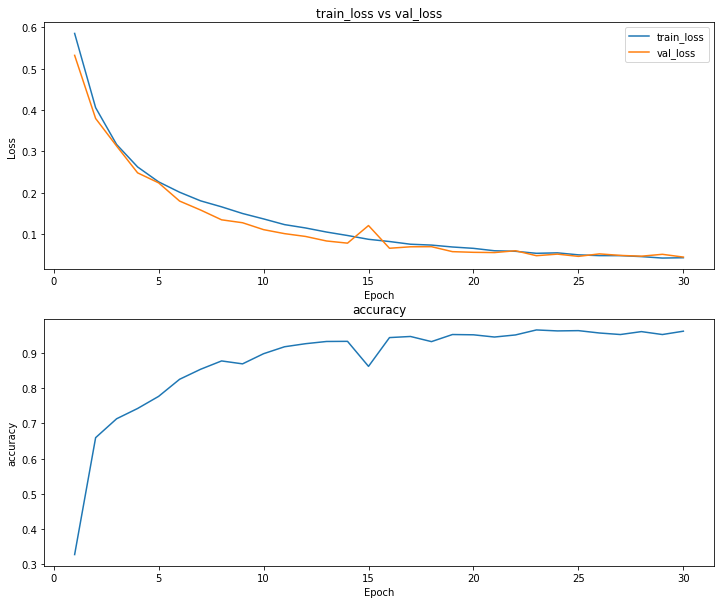

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [55]:
fig, axs = plt.subplots(2,1, figsize=(12,10))
for i in range(3):
    draw_loss_metric(history)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')

In [37]:
train = pd.read_csv('..\data/train.csv')
print("train.shape:", train.shape)
train.head()

train.shape: (50272, 2)


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [38]:
train['ImageId'] = train['ImageId_ClassId'].str[:-2]
train['ClassId'] = train['ImageId_ClassId'].str[-1:]
train['defect'] = train['EncodedPixels'].notnull()

train = train[['ImageId','ClassId','defect','EncodedPixels']]
train.head()

,ImageId,ClassId,defect,EncodedPixels
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg,2,False,NaN
2,0002cc93b.jpg,3,False,NaN
3,0002cc93b.jpg,4,False,NaN
4,00031f466.jpg,1,False,NaN


In [39]:
train = train.pivot(index='ImageId', columns='ClassId', values='EncodedPixels')
train = train.reset_index().rename_axis(None, axis=1)
train.to_csv('train_rle_pivot.csv', index=False)
train

,ImageId,1,2,3,4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN
1,00031f466.jpg,NaN,NaN,NaN,NaN
2,000418bfc.jpg,NaN,NaN,NaN,NaN
3,000789191.jpg,NaN,NaN,NaN,NaN
4,0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN
...,...,...,...,...,...
12563,fff0295e1.jpg,NaN,NaN,NaN,NaN
12564,fff02e9c5.jpg,NaN,NaN,207523 3 207777 9 208030 15 208283 22 208537 2...,NaN
12565,fffe98443.jpg,NaN,NaN,105929 5 106177 14 106424 24 106672 33 106923 ...,NaN
12566,ffff4eaa8.jpg,NaN,NaN,16899 7 17155 20 17411 34 17667 47 17923 60 18...,NaN


In [31]:
def rle2mask(rle, imgshape = (256,1600)):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

def build_masks(rles, input_shape = (256,1600)):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (height, width))
    
    return masks

In [35]:
masks = build_masks(train.loc[0, ['1','2','3','4']].values)
masks.shape

(256, 1600, 4)